In [1]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn==1.5.2
#!pip install scipy
#!pip install imblearn
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, sqrt, atan2
from imblearn.under_sampling import NearMiss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer,OneHotEncoder
from scipy.sparse import hstack,csr_matrix

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
#from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score,recall_score,classification_report,precision_recall_curve,roc_curve,roc_auc_score

## Load Data in train and test

In [4]:
train = pd.read_csv("../Dataset/credit_card_transaction_train.csv")
test = pd.read_csv("../Dataset/credit_card_transaction_test.csv")

## Basic Analysis of Datasets

In [5]:
train.shape, test.shape

((1296675, 24), (555719, 24))

In [6]:
all(train.columns == test.columns)

True

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [9]:
#Null Values
nullsTrain=train.isna().sum()
nullsTrain=nullsTrain[nullsTrain>0]

nullsTest=test.isna().sum()
nullsTest=nullsTest[nullsTest>0]

nullsPercentTrain=nullsTrain/train.shape[0]
nullsPercentTest=nullsTest/test.shape[0]

nullsPercentTrain , nullsPercentTest

(merch_zipcode    0.151135
 dtype: float64,
 merch_zipcode    0.151125
 dtype: float64)

## Removing Null values
- Null values contribute to 15% of training data. 
- Testing data should be clean.

In [10]:
#Removing Null Values
train.dropna(inplace=True,axis=0)
test.dropna(inplace=True,axis=0)

In [11]:
train.shape, test.shape

((1100702, 24), (471736, 24))

.

## Feature Engineering (Converting DoB to Age)

In [12]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])

In [13]:
train['dob'] = pd.to_datetime(train['dob'])
test['dob'] = pd.to_datetime(test['dob'])

In [14]:
train['age'] = train['trans_date_trans_time'].dt.year - train['dob'].dt.year
test['age'] = test['trans_date_trans_time'].dt.year - test['dob'].dt.year

In [15]:
train.drop("dob",axis=1,inplace=True)
test.drop("dob",axis=1,inplace=True)

## Feature Engineering (Calculating Distance Between Customer & Merchant)

In [16]:
# Transaction Distance: Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [17]:
train['transaction_distance'] = train.apply(
    lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)

In [18]:
test['transaction_distance'] = test.apply(
    lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)

## Feature Engineering (Transaction Seconds from Mid-Night)

In [19]:
train['sec_from_midnight'] = train['trans_date_trans_time'].dt.hour * 3600 + train['trans_date_trans_time'].dt.minute * 60 + train['trans_date_trans_time'].dt.second

In [20]:
test['sec_from_midnight'] = test['trans_date_trans_time'].dt.hour * 3600 + test['trans_date_trans_time'].dt.minute * 60 + test['trans_date_trans_time'].dt.second

## Feature Engineering (Transaction Frequency)

In [21]:
train['trans_date_trans_time'] = train['trans_date_trans_time'].dt.date
test['trans_date_trans_time'] = test['trans_date_trans_time'].dt.date

In [22]:
train['trans_count_per_day'] = train.groupby(['cc_num', 'trans_date_trans_time'])['trans_date_trans_time'].transform('count')
test['trans_count_per_day'] = test.groupby(['cc_num', 'trans_date_trans_time'])['trans_date_trans_time'].transform('count')

## Remove index and unwanted columns

In [23]:
#Remove index columns
colsToDrop= ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num','street','city','unix_time']
train.drop(colsToDrop,axis=1,inplace=True)
test.drop(colsToDrop,axis=1,inplace=True)

In [24]:
train.shape, test.shape

((1100702, 18), (471736, 18))

.

## Spliting Independent and Dependent variables

In [25]:
x_train = train.drop("is_fraud",axis=1)
x_test  = test.drop("is_fraud",axis=1)

y_train = train["is_fraud"]
y_test  = test["is_fraud"]

In [26]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((1100702, 17), (471736, 17), (1100702,), (471736,))

## Data Transofrmation(Yeo-Johnson) and Standard Scaling

In [27]:
x_train.select_dtypes(exclude="object").skew()

amt                     44.548930
zip                      0.142397
lat                     -0.349471
long                    -1.052179
city_pop                 5.600689
merch_lat               -0.340692
merch_long              -1.051067
merch_zipcode            0.145648
age                      0.584944
transaction_distance    -0.212812
sec_from_midnight       -0.276700
trans_count_per_day      1.468756
dtype: float64

<Axes: xlabel='amt', ylabel='Density'>

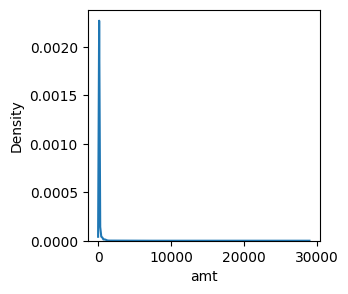

In [28]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

In [29]:
#Using PowerTransformer
TransformModel = PowerTransformer(method='yeo-johnson',standardize=True)
TransformModel.fit(x_train.select_dtypes(exclude="object"))

PowerTransformer()

In [30]:
numeric_cols = x_train.select_dtypes(exclude="object").columns

In [31]:
x_train[numeric_cols] = TransformModel.transform(x_train[numeric_cols])
x_test[numeric_cols] = TransformModel.transform(x_test[numeric_cols])

In [32]:
x_train.shape , x_test.shape

((1100702, 17), (471736, 17))

In [33]:
x_train.select_dtypes(exclude="object").skew()

amt                    -0.014016
zip                    -0.188598
lat                    -0.045696
long                   -0.052577
city_pop                0.059247
merch_lat              -0.046212
merch_long             -0.052247
merch_zipcode          -0.184831
age                    -0.016294
transaction_distance   -0.160462
sec_from_midnight      -0.376678
trans_count_per_day     0.004092
dtype: float64

<Axes: xlabel='amt', ylabel='Density'>

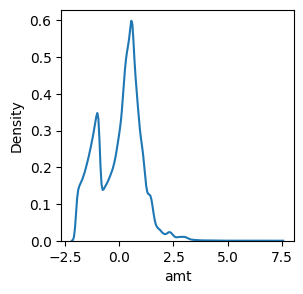

In [34]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

#### There still lots of values beyond 6-Sigma so, have to Impute outliers to ensure normality as well as prevent data loss  

## Outlier Handling

In [35]:
def outRemove(x):
    if x>3: return 3
    elif x<-3: return -3
    else: return x

In [36]:
x_train[numeric_cols] = x_train[numeric_cols].applymap(outRemove)
x_test[numeric_cols] = x_test[numeric_cols].applymap(outRemove)

C:\Users\GhungruTree3\AppData\Local\Temp\ipykernel_9812\982681809.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x_train[numeric_cols] = x_train[numeric_cols].applymap(outRemove)
C:\Users\GhungruTree3\AppData\Local\Temp\ipykernel_9812\982681809.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x_test[numeric_cols] = x_test[numeric_cols].applymap(outRemove)


<Axes: xlabel='amt', ylabel='Density'>

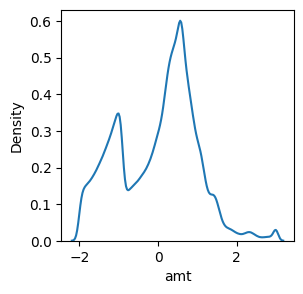

In [37]:
plt.figure(figsize=(3,3))
sns.kdeplot(x_train["amt"], label="amt")

## Correalation Analysis to find Multi-Colinearity

<Axes: >

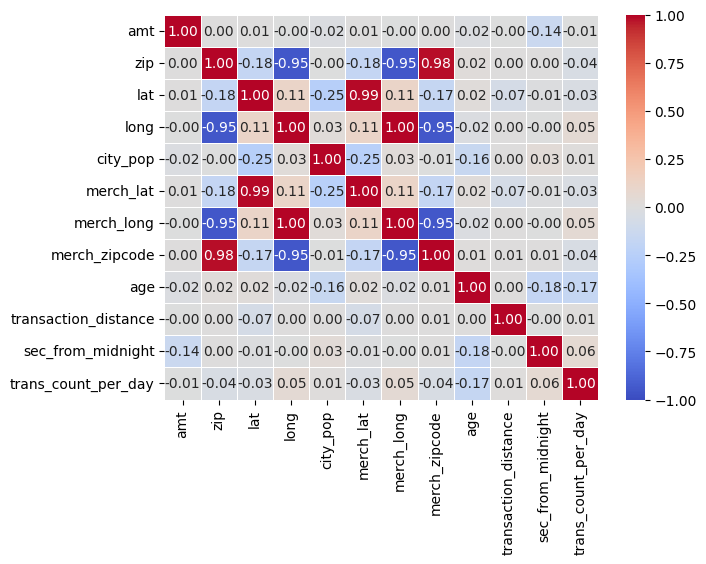

In [38]:
plt.figure(figsize=(7, 5))
sns.heatmap(x_train.select_dtypes(exclude='object').corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

In [39]:
corrColsToDrop= ['merch_long','merch_lat','merch_zipcode','long']
x_train.drop(corrColsToDrop,axis=1,inplace=True)
x_test.drop(corrColsToDrop,axis=1,inplace=True)

<Axes: >

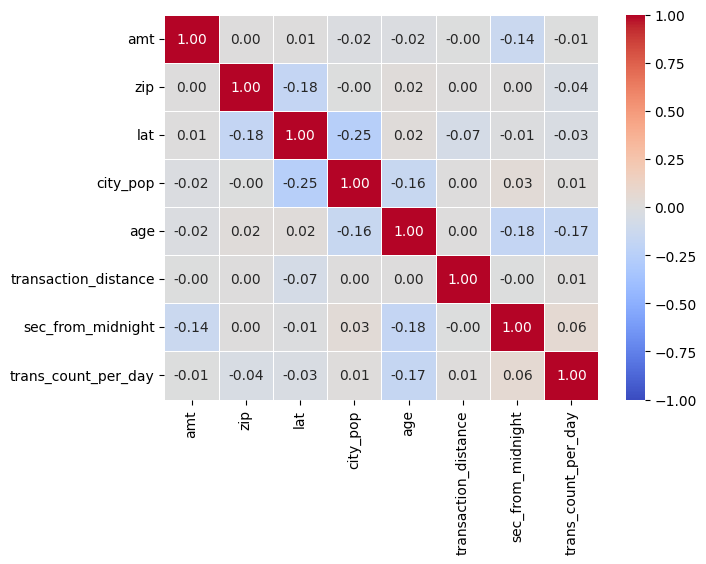

In [40]:
plt.figure(figsize=(7, 5))
sns.heatmap(x_train.select_dtypes(exclude='object').corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

## Encoding 

In [41]:
x_train.dtypes

merchant                 object
category                 object
amt                     float64
gender                   object
state                    object
zip                     float64
lat                     float64
city_pop                float64
job                      object
age                     float64
transaction_distance    float64
sec_from_midnight       float64
trans_count_per_day     float64
dtype: object

### Have to use Sparse Matrix for OneHot Encoding due large size of data

In [42]:
x_train.head()

,merchant,category,amt,gender,state,zip,lat,city_pop,job,age,transaction_distance,sec_from_midnight,trans_count_per_day
0,"fraud_Rippin, Kub and Mann",misc_net,-1.320840,F,NC,-0.607863,-0.594835,0.055191,"Psychologist, counselling",-0.864597,0.114764,-2.093899,-0.376643
2,fraud_Lind-Buckridge,entertainment,1.539206,M,ID,1.312087,0.788460,0.131564,Nature conservation officer,0.707510,1.143003,-2.090995,-1.775558
4,fraud_Keeling-Crist,misc_pos,0.117777,M,VA,-0.794243,-0.091899,-1.926591,Dance movement psychotherapist,-0.714226,0.078987,-2.080575,0.063910
5,"fraud_Stroman, Hudson and Erdman",gas_transport,0.783936,F,PA,-1.054852,0.354408,-0.166549,Transport planner,0.756035,0.367320,-2.076126,-1.775558
7,fraud_Corwin-Collins,gas_transport,0.549313,M,VA,-0.868044,0.002531,0.290206,"Designer, multimedia",1.377104,-2.066692,-2.071937,-0.376643


In [43]:
non_numeric_cols = x_train.select_dtypes("object").columns
numeric_cols = x_train.select_dtypes(exclude="object").columns

In [44]:
x_train[non_numeric_cols].nunique()

merchant    693
category     14
gender        2
state        50
job         493
dtype: int64

In [45]:
x_train_NonNumeric = x_train[non_numeric_cols]
x_train_Numeric = x_train[numeric_cols]

x_test_NonNumeric = x_test[non_numeric_cols]
x_test_Numeric = x_test[numeric_cols]

In [46]:
enCoder = OneHotEncoder(handle_unknown='infrequent_if_exist',drop="first",sparse_output=True)
enCoder.fit(x_train_NonNumeric)

OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')

In [47]:
x_train_NonNumeric_np = enCoder.transform(x_train_NonNumeric)
x_test_NonNumeric_np = enCoder.transform(x_test_NonNumeric)

C:\Users\GhungruTree3\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
x_train_Numeric_np = csr_matrix(x_train_Numeric.values)
x_test_Numeric_np = csr_matrix(x_test_Numeric.values)

In [49]:
x_train_np = hstack([x_train_Numeric_np, x_train_NonNumeric_np])
x_test_np = hstack([x_test_Numeric_np, x_test_NonNumeric_np])

.

## Treat Class-Imbalance

C:\Users\GhungruTree3\AppData\Local\Temp\ipykernel_9812\592855909.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(train['is_fraud'])


Text(0, 0.5, 'Frequency')

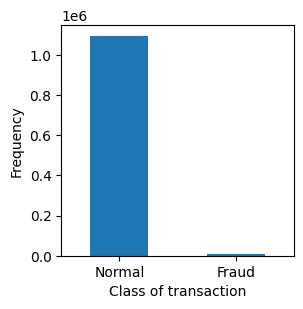

In [50]:
# plotting the classes
plt.figure(figsize=(3,3))
count_classes = pd.value_counts(train['is_fraud'])
count_classes.plot(kind = 'bar',rot=0)
LABELS = ['Normal','Fraud']
plt.xticks(range(2), LABELS)
plt.xlabel("Class of transaction")
plt.ylabel("Frequency")

In [51]:
print(count_classes.iloc[0]/count_classes.iloc[1])

171.98475561841897


## UnderSampling using NearMiss

In [52]:
nr = NearMiss(sampling_strategy=0.1) 
x_train_np, y_train = nr.fit_resample(x_train_np, y_train)
print('Near Miss:')
print(y_train.value_counts())

Near Miss:
is_fraud
0    63630
1     6363
Name: count, dtype: int64


## Feature Selection (SelectFromModel)

In [53]:
rf_Model = RandomForestClassifier(random_state=117,class_weight="balanced_subsample")
FeatureSelect_Model = SelectFromModel(rf_Model)
FeatureSelect_Model.fit(x_train_np,y_train)

SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                 random_state=117))

In [54]:
x_train_np = FeatureSelect_Model.transform(x_train_np)
x_test_np = FeatureSelect_Model.transform(x_test_np)

## Model Building

In [55]:
rf_model = RandomForestClassifier(random_state=117,class_weight="balanced_subsample",oob_score=True)
rf_model.fit(x_train_np,y_train)

RandomForestClassifier(class_weight='balanced_subsample', oob_score=True,
                       random_state=117)

In [56]:
y_pred_rf = rf_model.predict_proba(x_test_np)[:, 1] >= 0.5
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    469863
           1       0.82      0.80      0.81      1873

    accuracy                           1.00    471736
   macro avg       0.91      0.90      0.90    471736
weighted avg       1.00      1.00      1.00    471736



In [57]:
xg_model = xgb.XGBClassifier(eval_metric='logloss',random_state=117,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
xg_model.fit(x_train_np, y_train.to_numpy())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=117, ...)

In [58]:
y_pred_xg = xg_model.predict_proba(x_test_np)[:, 1] >= 0.5
print(classification_report(y_test,y_pred_xg))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    469863
           1       0.21      0.94      0.35      1873

    accuracy                           0.99    471736
   macro avg       0.61      0.96      0.67    471736
weighted avg       1.00      0.99      0.99    471736



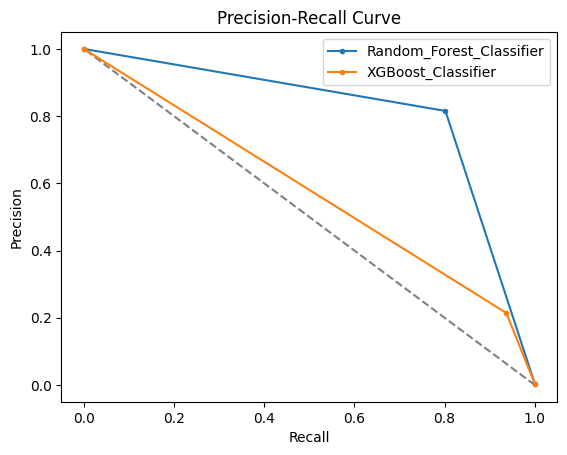

In [59]:
precision_rf, recall_rf, thresholds_PR_rf = precision_recall_curve(y_test, y_pred_rf)
precision_xg, recall_xg, thresholds_PR_xg = precision_recall_curve(y_test, y_pred_xg)

plt.plot([1, 0], [0, 1], color='gray', linestyle='--')

plt.plot(recall_rf, precision_rf, marker='.',label="Random_Forest_Classifier")
plt.plot(recall_xg, precision_xg, marker='.',label="XGBoost_Classifier")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

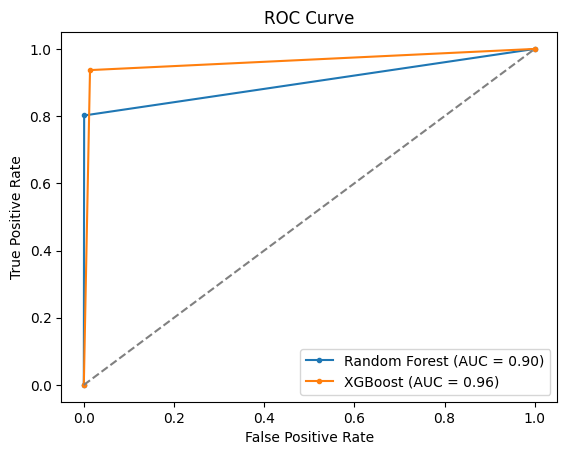

In [60]:
fpr_rf, tpr_rf, thresholds_ROC_rf = roc_curve(y_test, y_pred_rf)
fpr_xg, tpr_xg, thresholds_ROC_xg = roc_curve(y_test, y_pred_xg)

roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_xg = roc_auc_score(y_test, y_pred_xg)

plt.plot(fpr_rf, tpr_rf, marker='.', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xg, tpr_xg, marker='.', label=f'XGBoost (AUC = {roc_auc_xg:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### PR-Graph says RandomForrest is more generalized to predict Frauds/Normal classes...
### ROC-Curve says XGBoost is Focusing on "Recall"->False Negative values, As it does not let frauds to mark as Normal-Trasactions

In [73]:
#import joblib

In [74]:
#joblib.dump(rf_model, "../Models/random_forest_classifier_model.pkl")

In [75]:
#joblib.dump(xg_model, "../Models/xgBoost_model.pkl")

In [76]:
#joblib.dump(enCoder, "../Models/oneHotEncoder_model.pkl")

In [77]:
#joblib.dump(TransformModel, "../Models/PowerTransform_StdScaling_model.pkl")

In [78]:
#joblib.dump(FeatureSelect_Model, "../Models/feature_selection_model.pkl")